# minHash Image Clustering (MHIC) algorithm (Seed Generation Only)

Implementation based on 
* [Large-Scale Discovery of Spatially Related Images](ieeexplore.ieee.org/iel5/34/4359286/05235143.pdf) by Ondrej Chum and Jiri Matas
* [Scalable Near Identical Image and Shot Detection - Microsoft](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/civr2007.pdf) by Ondrej Chum, James Philbin, Michael Isard, Andrew Zisserman

## Purpose

If we see a similar image cluster as a connected compoenent, images are vertex. 
We have to find edges to get image cluster. minHash can be used to find subset of the edges quickly. 

Afterward, you may use image retrieval system to complete the connected component. 


## Requirements

* Visual words index list for each image

In [1]:
import os
import pickle

# bow_dict_save_path = 'bow_dict_word_oxc1_hesaff_sift_16M_1M_pretrained.pkl'
# vocab_size=1000000

# bow_dict_save_path = 'bow_dict_word_oxc1_hesaff_sift_16M_100k_handmade.pkl'
# vocab_size = 2**17

# bow_dict_save_path = 'bow_dict_word_oxc1_hesaff_sift_16M_1M_4_sub_handmade.pkl'
# vocab_size = 2**17

bow_dict_save_path = 'bow_dict_word_oxc1_hesaff_sift_16M_1M_8_sub_handmade.pkl'
vocab_size = 2**17

with open(bow_dict_save_path, 'rb') as f:
    # key: image_name, value: list of visual word index
    bow_dict = pickle.load(f)

In [2]:
%load_ext autoreload
%autoreload 2
from utils.bow_utils import get_idf_word_weights

word_weights = get_idf_word_weights(bow_dict, vocab_size=vocab_size)
print(word_weights[:10]) # inverse document frequency. It is importance of the words. 

never used word detected. bow_index: 6536. It is weird. please check your implementation again.
never used word detected. bow_index: 8538. It is weird. please check your implementation again.
never used word detected. bow_index: 11468. It is weird. please check your implementation again.
never used word detected. bow_index: 12087. It is weird. please check your implementation again.
never used word detected. bow_index: 12644. It is weird. please check your implementation again.
never used word detected. bow_index: 13930. It is weird. please check your implementation again.
never used word detected. bow_index: 14097. It is weird. please check your implementation again.
never used word detected. bow_index: 15522. It is weird. please check your implementation again.
never used word detected. bow_index: 17257. It is weird. please check your implementation again.
never used word detected. bow_index: 17444. It is weird. please check your implementation again.
never used word detected. bow_in

In [ ]:
%load_ext autoreload
%autoreload 2
# from utils.minhash_utils import VisualMinHashWithDataSketch
from utils.minhash_utils import SketchCollisionTester, VisualMinHashWithLookupTable
from utils.minhash_utils import get_collision_pairs

def print_similar_paris_statistics(similar_pairs, th_sim_min, th_sim_max):
    similar_pairs = list(similar_pairs)
    print('len similar_pairs:', len(similar_pairs))
    similar_pairs.sort(key=lambda x: x[1])
    print('similar_pairs[:5]:', similar_pairs[:5])

    count_irr = 0
    count_sim = 0
    count_dup = 0

    for image_cluster, score in similar_pairs:
        if score < THRESHOLD_DATAMINING_SIMILARITY_MIN:
            count_irr += 1            
        elif score >= THRESHOLD_DATAMINING_SIMILARITY_MIN and score < THRESHOLD_DATAMINING_SIMILARITY_MAX:
            count_sim += 1
        else:
            count_dup += 1
    print("count (irr, sim, dup) : ({}, {}, {})".format(count_irr, count_sim, count_dup))
    

collision_tester = SketchCollisionTester(minHash_param_k=512)        
# vmh = VisualMinHashWithDataSketch(minHash_hash_num=512, minHash_param_k=512, minHash_param_s=3)
vmh = VisualMinHashWithLookupTable(minHash_hash_num=512, vocab_size=vocab_size, word_weights=word_weights, minHash_param_k=512, minHash_param_s=3)

similar_pairs = get_collision_pairs(bow_dict, vmh, collision_tester)

# For datamining purpose, we want to get less simlar but the same scene. 
# So we are interested in similiarity in [THRESHOLD_DATAMINING_SIMILARITY_MIN, THRESHOLD_DATAMINING_SIMILARITY_MAX]
# See Large-Scale Discovery of Spatially Related Images. Sec 3.2 for THRESHOLD_DATAMINING_SIMILARITY_MIN
# See Scaleable Near Identical Image and Shot Detection. Sec 4.3 for THRESHOLD_DATAMINING_SIMILARITY_MAX
THRESHOLD_DATAMINING_SIMILARITY_MIN = 0.045 
THRESHOLD_DATAMINING_SIMILARITY_MAX = 0.35

print_similar_paris_statistics(similar_pairs, THRESHOLD_DATAMINING_SIMILARITY_MIN, THRESHOLD_DATAMINING_SIMILARITY_MAX)

# Timing: 5062 images took 2 min 30 sec. 

# History: 
# Oxf5k, 16M features, 1M cluster(visual_words), count (irr, sim, dup) : 
# Oxf5k, 16M features, codebook train size 100k with 4 subspaces, 2^17 cluster(visual_words), count (irr, sim, dup) : (15348, 1141, 2)
# Oxf5k, 16M features, codebook train size 1M with 4 subspaces, 2^17 cluster(visual_words), count (irr, sim, dup) : (15587, 1155, 2)
# Oxf5k, 16M features, codebook train size 1M with 8 subspaces, 2^17 cluster(visual_words), count (irr, sim, dup) : (12775, 724, 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home1/irteam/user/insikk/bow_image_retrieval/utils/minhash_utils.py:139: RuntimeWarning: divide by zero encountered in true_divide
  self.hash_funcs = (-1)*np.log(np.random.uniform(size=(minHash_hash_num, vocab_size))) / word_weights
 69%|██████▉   | 3499/5062 [01:51<00:49, 31.29it/s]

In [81]:
%load_ext autoreload
%autoreload 2
from multiprocessing import Pool
from utils.geo_verif_utils import get_ransac_inlier, draw_ransac
import cv2

def get_keypoints(image_name):
    # Oxford 5k dataset provides already converted visual words. We could use this one
    import os 
    oxf5k_visualword_dir = './data/word_oxc1_hesaff_sift_16M_1M'

    filepath = os.path.join(oxf5k_visualword_dir, image_name + ".txt")
    kp = []
    with open(filepath) as f:
        lines = list(map(lambda x: x.strip(), f.readlines()[2:])) # ignore first two lines        
        for l in lines:
            val = l.split(" ")
            visual_word_index = int(val[0])-1 # This data use 1 to 1,000,000. convert to zero-based so 0 to 999,999  
            x = float(val[1])
            y = float(val[2])
            a = float(val[3])
            b = float(val[4])
            c = float(val[5])
            # TODO: generate ellipse shaped key point
            # Refer: https://math.stackexchange.com/questions/1447730/drawing-ellipse-from-eigenvalue-eigenvector
            # Refer: http://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/display_features.m
            # Refer: http://www.robots.ox.ac.uk/~vgg/research/affine/detectors.html
            key_point = cv2.KeyPoint(x, y, 1)
            kp.append(key_point)
    return kp
    

image_descriptor_dict_path = 'image_descriptor_dict_oxc1_hesaff_sift_16M.pkl'
with open(image_descriptor_dict_path, 'rb') as f:
    # key: image_name, value: 2d numpy array of shape (num_descriptor, dim_descriptor)
    image_descriptor_dict = pickle.load(f) 
    
IMAGE_DIR = "./data/oxford/oxford5k/images"

    
def show_image_pair_ransac(image_dir, image_names, kp1, kp2, des1, des2):
    """
    show image cluster for oxford 5k dataset
    """
    # Visualize images assigned to this cluster    
    from PIL import Image
    import matplotlib.pyplot as plt
    
    imgs = []    
    for image_name in image_names:
        image_name = image_name.replace("oxc1_", "") + ".jpg"
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        imgs.append(img)
        
    return draw_ransac(imgs[0], imgs[1], kp1, kp2, des1, des2, False, 'BRUTE_FORCE', None)
    

def parallel_task(val):
    image_cluster, score = val
    print(val)
    kp1 = get_keypoints(image_cluster[0])
    des1 = image_descriptor_dict[image_cluster[0]]
    kp2 = get_keypoints(image_cluster[1])
    des2 = image_descriptor_dict[image_cluster[1]]
    num_inlier = get_ransac_inlier(kp1, kp2, des1, des2)
    # num_inlier = show_image_pair_ransac(IMAGE_DIR, image_cluster, kp1, kp2, des1, des2)
    return (image_cluster, score, num_inlier)
    
def filter_keep_similar_only(score):
    return score >= THRESHOLD_DATAMINING_SIMILARITY_MIN and score < THRESHOLD_DATAMINING_SIMILARITY_MAX

if __name__ == '__main__':
    pool = Pool(processes=10)
    cluster_seed = []    
    # similar_pairs = list(filter(lambda x: filter_kepp_similar_only(x[1]), similar_pairs))
    for result in tqdm(pool.imap_unordered(parallel_task, similar_pairs), total=len(similar_pairs)):
        if result is not None:
            cluster_seed.append(result)
    print(cluster_seed[:5])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload





  0%|          | 0/13501 [00:00<?, ?it/s]

(('oxc1_ashmolean_000153', 'oxc1_ashmolean_000280'), 0.004364525139664804)


(('oxc1_oxford_001831', 'oxc1_oxford_003041'), 0.004383561643835616)
(('oxc1_oxford_002374', 'oxc1_trinity_000077'), 0.0044897254360214125)
(('oxc1_balliol_000148', 'oxc1_oxford_000695'), 0.004899559039686428)
(('oxc1_christ_church_000077', 'oxc1_keble_000091'), 0.0052044609665427505)
(('oxc1_ashmolean_000014', 'oxc1_bodleian_000438'), 0.005591798695246971)
(('oxc1_all_souls_000213', 'oxc1_magdalen_000671'), 0.005424464334147003)
(('oxc1_magdalen_001034', 'oxc1_oxford_003530'), 0.005245672320335723)
(('oxc1_ashmolean_000153', 'oxc1_magdalen_000988'), 0.005319148936170213)
(('oxc1_keble_000113', 'oxc1_oxford_001865'), 0.0054691505725517)


KeyboardInterrupt: 

Sampling from irrelevant images.
pair: ('oxc1_oxford_000190', 'oxc1_radcliffe_camera_000233'), score: 0.01837600125647872


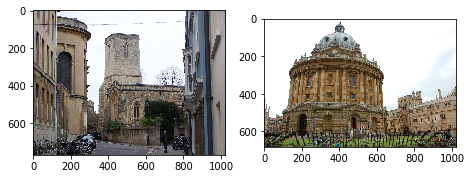



pair: ('oxc1_oxford_000177', 'oxc1_oxford_002494'), score: 0.03251091119622339


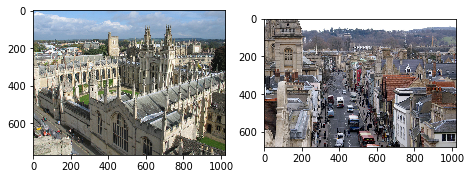



pair: ('oxc1_hertford_000018', 'oxc1_radcliffe_camera_000470'), score: 0.019760790431617263


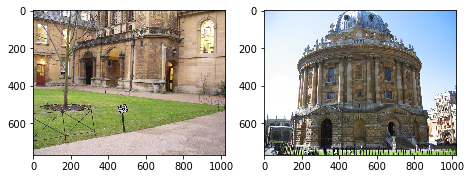



pair: ('oxc1_oxford_000533', 'oxc1_oxford_000858'), score: 0.03088110303144773


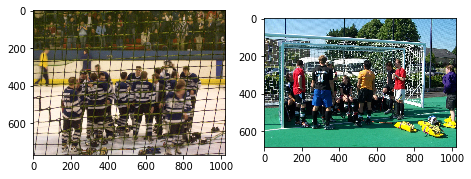



pair: ('oxc1_oxford_003353', 'oxc1_pitt_rivers_000139'), score: 0.01875390706397166


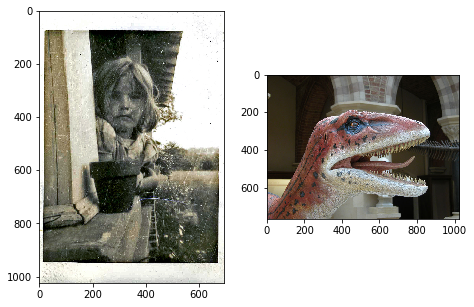



pair: ('oxc1_christ_church_000683', 'oxc1_magdalen_000020'), score: 0.022776055330312427


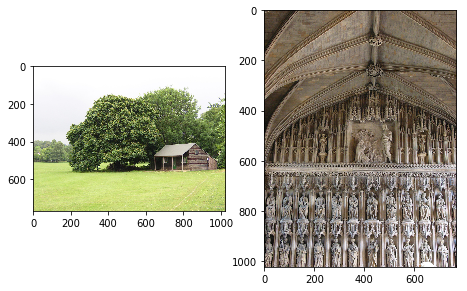



pair: ('oxc1_ashmolean_000148', 'oxc1_oxford_002592'), score: 0.015971010602603676


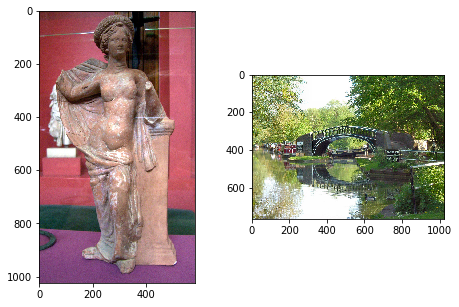



pair: ('oxc1_magdalen_000874', 'oxc1_trinity_000081'), score: 0.02982681205901219


KeyboardInterrupt: 

In [67]:
import random
def show_image_cluster(image_dir, image_names):
    """
    show image cluster for oxford 5k dataset
    """
    # Visualize images assigned to this cluster    
    from PIL import Image
    import matplotlib.pyplot as plt
    
    imgs = []    
    for image_name in image_names:
        image_name = image_name.replace("oxc1_", "") + ".jpg"
        image_path = os.path.join(image_dir, image_name)
        img = Image.open(image_path)
        imgs.append(img)            
        
    cols = 5
    imgs = imgs[:cols]
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
    plt.show()

    
# IMAGE_DIR = "./data/oxford5k_images"
IMAGE_DIR = "./data/oxford/oxford5k/images"
sample_count = 10
print("Sampling from irrelevant images.")
target_seq = similar_pairs[:count_irr]
k = min(sample_count, len(target_seq))
for image_cluster, score in random.sample(target_seq, k):
    print("pair: {}, score: {}".format(image_cluster, score))
    show_image_cluster(IMAGE_DIR, image_cluster)
    print('\n')    
    

In [ ]:

print("Sampling from similar images.")
target_seq = similar_pairs[count_irr:count_irr+count_sim]
k = min(sample_count, len(target_seq))
target_seq.sort(key=lambda x: x[1], reverse=True)
for image_cluster, score in target_seq:
    print("pair: {}, score: {}".format(image_cluster, score))
    show_image_cluster(IMAGE_DIR, image_cluster)
    print('\n')    
    
print("Sampling from near-duplicates images.")
target_seq = similar_pairs[count_irr+count_sim:]
target_seq.sort(key=lambda x: x[1], reverse=True)
k = min(sample_count, len(target_seq))
for image_cluster, score in random.sample(target_seq, k):
    print("pair: {}, score: {}".format(image_cluster, score))
    show_image_cluster(IMAGE_DIR, image_cluster)
    print('\n')    